# Exercice 1 - Simple 2D model

This first exercise will present the basic capabilities of ArchPy (how to define the stratigraphic pile, how to import boreholes and how to visualize the data and models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import geone
import geone.covModel as gcm
import pyvista as pv
import ArchPy

## Building the model

Let's see step by step how to build an ArchPy model.

### Arch table object

The very first step is to instantiate an Arch_table object. This is the main object of ArchPy that contains all the useful functions (preprocessing, computing, plotting, etc.). It can be seen as the project.

The syntax is pretty simple: ``ArchPy.base.Arch_table(name = ..., seed = ..., verbose = ...)``.

- ``name``, string, corresponds to the project name and will be used as an identifier
- ``seed``, int, is the seed for the reproducibility of the stochastic events
- ``verbose`` is the level of information that will be printed by ArchPy, 0 for quasi-None and 1 for everything.

In [2]:
T1 = ArchPy.base.Arch_table(name = "Example1", seed = 15, verbose = 1)

### Grid

Next we can define a simulation grid. In ArchPy, grids are simple regular cartesian grids and only required three inputs:
- ``dimensions`` (nx, ny, nz), the number of cells in three directions
- ``spacing`` (sx, sy, sz), the size of the cells in each directions
- ``origin`` (ox, oy, oz), the origin of the grid

For this exercise, let us a define a 2D slice grid of nx = 200 and nz = 100 with a spacing of sx = 0.5 and sz = 0.15. The origin is x0 = 0, y0 = 0 and z0 = -15.

The grid can be added to the arch table with the ``add_grid()`` method.

In [3]:
# grid

sx = 0.5
sy = 1
sz = 0.15
x0 = 0
y0 = 0
z0 = -15
nx = 200
ny = 1
nz = 100

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

## add grid to the arch table
T1.add_grid(dimensions, spacing, origin)

## Adding Grid ##
## Grid added and is now simulation grid ##


### Units and surfaces

Let us now create three stratigraphic units: C, B and A (C is above B which is above A). 

This is done with the classes ArchPy.base.Unit and ArchPy.base.Surface

**For each unit, a surface must be defined.** This surface delimits the top of the unit.

A surface is caracterized by : 
- contact type (onlap or erode), which influences how it interacts with other surfaces - Surface dictionnary (dic_surf) wich includes all parameters and method interpolations
- dic_surf: a python dictionary that contains many parameters:
    - int_method : interpolation method --> grf, grf_ineq, MPS, kriging, ... 
    - covmodel : covariance model to use if int_method is grf, grf_ineq, kriging
    - mean : mean elevation of the surface
    - etc.

A unit is caracterized by : 
- a name
- an order that defines the unit position in the pile, ranging from 1 (youngest unit) to n (oldest unit).
- a surface object
- Unit dictionnary (dic_facies), more info below ! 

In [40]:
# units
#units covmodel
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':.5, 'r':[40, 40]})])
covmodelA = gcm.CovModel2D(elem=[('cubic', {'w':8, 'r':[30, 30]})])


# create Units 

# C unit as example
surf_C = ArchPy.base.Surface()
C = ArchPy.base.Unit(name = "C", order = 1, ID = 1, color = "lightblue",
                     surface = surf_C)


# Do not forget to add the covmodels to surface of B and A !

dic_s_B = {"int_method" : "grf_ineq" ,"covmodel" : covmodelB}
surf_B = ArchPy.base.Surface(dic_surf=dic_s_B, contact="onlap")  # create a surface object
B = ArchPy.base.Unit(name = "B", order = 2, ID = 2, color="gold",
                     surface = surf_B)


dic_s_A = {"int_method" : "grf_ineq" ,"covmodel" : covmodelA}
surf_A = ArchPy.base.Surface(dic_surf=dic_s_A, contact="onlap")  # create a surface object
A = ArchPy.base.Unit(name = "A", order = 3, ID = 3, color="red",
                     surface = surf_A)

Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation


### Pile

Finally, the units are added to a Pile object with the ``add_unit`` method of the Pile.

In [5]:
P1 = ArchPy.base.Pile(name = "P1")  # create a pile object
P1.add_unit([C, B, A])  # add units

T1.set_Pile_master(P1) # define the main pile

Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added
Pile sets as Pile master


### Boreholes

Let's see now how to import boreholes into the model.

For this ArchPy requires three different data text files.: a list of borholes, a list of unit data and a list of facies data.

They can have any extensions but the recommended are :

list of boreholes -> .lbh

list of unit data -> .ud

list of facies data -> .fd

For this example, the files are in the 2_data_folder.

Let's detail these files :
- .lbh : text file with five columns listing all the boreholes in the data. It has five columns and default headers are :
    - bh_ID : borehole identifier to know at which borehole a unit/facies data belongs
    - bh_x : x borehole coordinate
    - bh_y : y borehole coordinate
    - bh_z : z borehole coordinate
    - bh_depth : borehole depth


- .ud : text file with four columns listing all the stratigraphical unit interval data. Default headers are :
     - bh_ID : borehole identifier to know at whcih borehole the unit data belongs
     - Strat : Unit identifier to know at which unit this unit interval data belongs
     - top : top elevation of the interval
     - bot : bot elevation of the interval
    
        
- .fd : text file with four columns listing all the facies interval data. Default headers are :
     - bh_ID : borehole identifier to know at whcih borehole the unit data belongs
     - facies_ID : facies identifier to know at which facies this facies interval data belongs
     - top : top elevation of the interval
     - bot : bot elevation of the interval


First --> we have to import these files with pandas 

In [6]:
import pandas as pd

list_bhs = pd.read_csv("data/exo1.lbh")
unit_data = pd.read_csv("data/exo1.ud")
facies_data = pd.read_csv("data/exo1.fd")

In [7]:
unit_data.head()

,bh_ID,Strat,top,bot
0,1,C,-0.015038,-5.400
1,1,A,-5.400000,-14.925
2,2,C,-0.015038,-5.250
3,2,A,-5.250000,-14.925
4,3,C,-0.015038,-5.700


In [8]:
list_bhs.head()

,bh_ID,bh_x,bh_y,bh_z,bh_depth
0,1,42.018297,0.5,-0.015038,14.909962
1,2,36.323950,0.5,-0.015038,14.909962
2,3,18.487669,0.5,-0.015038,14.909962
3,4,51.828273,0.5,-0.015038,14.909962
4,5,0.860545,0.5,-0.015038,14.909962


In [9]:
facies_data.head()

,bh_ID,facies_ID,top,bot
0,1,Silt,-0.015038,-7.05
1,1,Clay,-7.050000,-7.80
2,1,Silt,-7.800000,-8.85
3,1,Clay,-8.850000,-9.00
4,1,Silt,-9.000000,-9.75


We can now import the boreholes with the following functions. I'm not going into the details but the first one create a uniform and clean geological base from the unit and facies data file. And the second create the borehole object for ArchPy.


Note that We don't import the facies information here (``extract_facies = False``).

In [10]:
db, lbhs = ArchPy.inputs.load_bh_files(list_bhs, facies_data, unit_data)
boreholes = ArchPy.inputs.extract_bhs(db, lbhs, T1, extract_facies=False, vb=1)

Let us add these boreholes to the table with ``add_bh()`` method

In [11]:
T1.add_bh(boreholes)

Borehole 1 added
Borehole 2 added
Borehole 3 added
Borehole 4 added
Borehole 5 added


We can see the boreholes with ``plot_bhs()`` method

In [12]:
pv.set_plot_theme("document")

In [13]:
T1.plot_bhs(plot_bot=True, plot_top=True)

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b6380d1690_0&reconnect=auto' style='width…

We still need to process these boreholes, i.e. extract the information for the simulations. fortunately, this is done automatically by archpy by simply using the ``process_bhs()`` method !

In [14]:
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


### Simulations

The three level of simulations can then be simulated with the following commands :

- ``compute_surf(nreal)``

- ``compute_facies(nreal)``

- ``compute_prop(nreal)``

Let's consider a total of 10 unit realizations (nreal = 10)

In [15]:
T1.compute_surf(6)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.00698089599609375 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003988742828369141 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.001994609832763672 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.006981372833251953 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003991127014160156 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0029897689819335938 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.00598454475402832 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surf

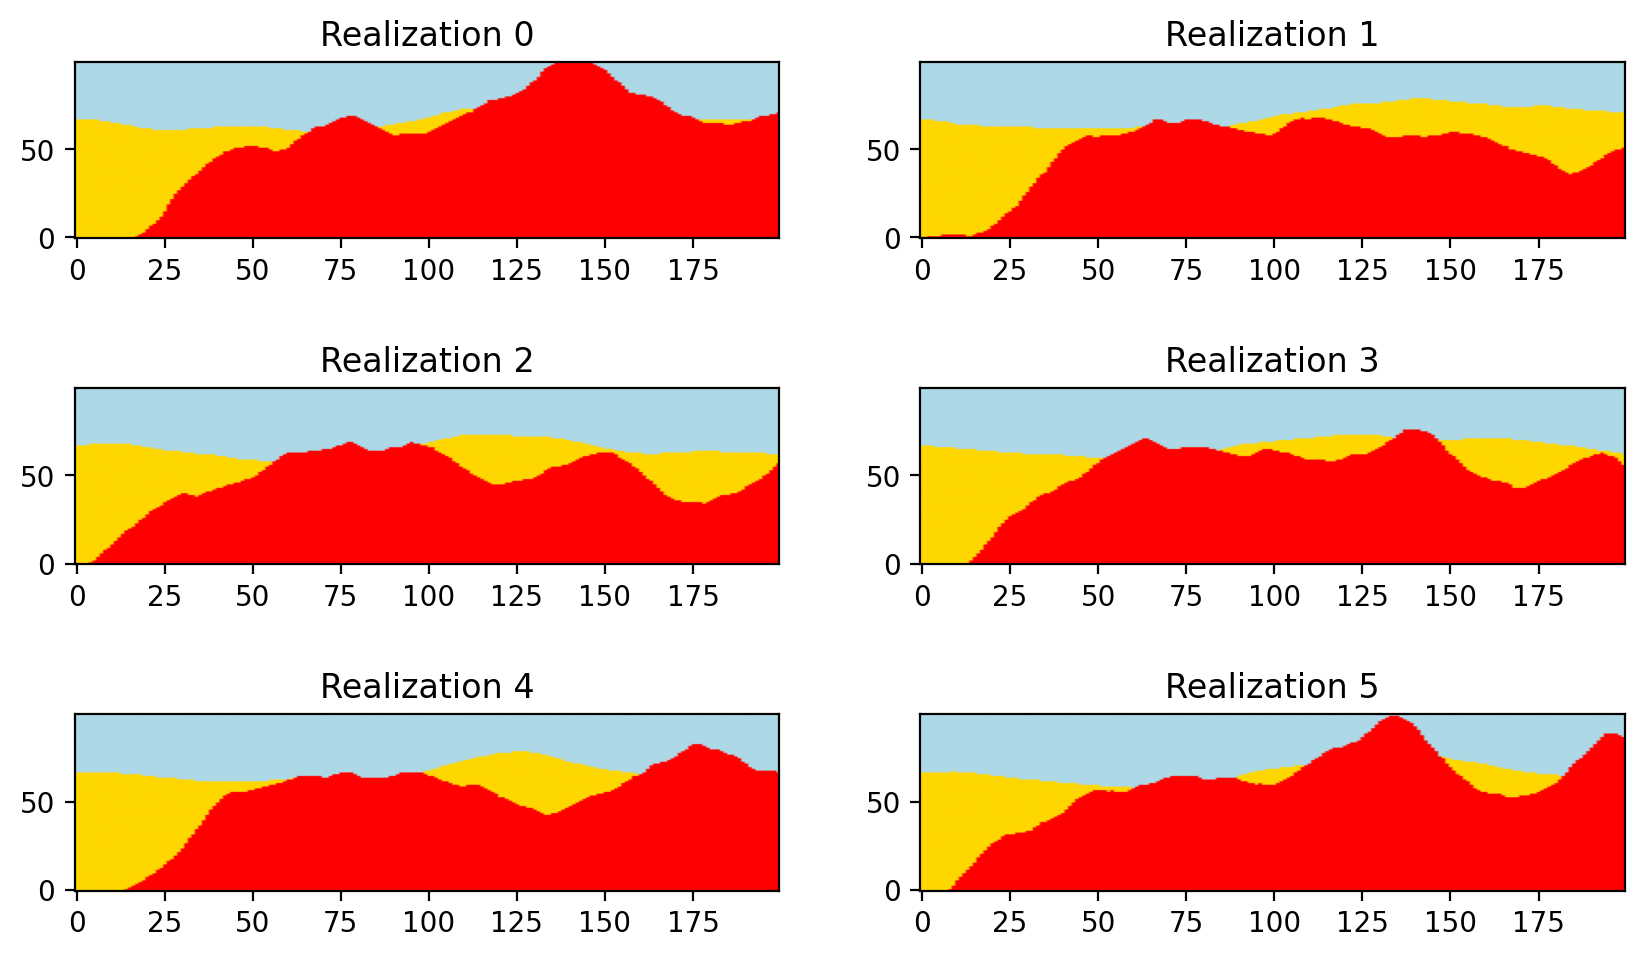

In [16]:
## plots

plt.figure(figsize=(10, 6), dpi=200)
for i in range(6):
    
    plt.subplot(3, 2, i+1)
    plt.imshow(T1.get_units_domains_realizations(i, fill="color")[:, 0], origin="lower", aspect=.5)
    plt.title("Realization {}".format(i))
    

## Testing with erode

This is nice but we can now test different options of ArchPy, for example the choice between onlap and erode of the surface. What happens if we modify the top surface of B to ``erode`` ?


In [17]:
## modify the contact of the surface of B
B.surface.contact = "erode"

In [18]:
# reprocess the boreholes
T1.bhs_processed = 0  # this line reset the flag that indicate that the boreholes are processed
T1.process_bhs()

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully


In [19]:
# re run simulations
T1.compute_surf(100)

########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.011966466903686523 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.005984067916870117 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.000997304916381836 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.003989458084106445 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0029904842376708984 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0019960403442382812 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.003988027572631836 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0029926300048828125 s

#### COMPUTING SURFACE OF UNIT C
C: time elaps


Time elapsed for getting domains 0.0019941329956054688 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0029921531677246094 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0029914379119873047 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0019958019256591797 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.003989219665527344 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003988742828369141 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0019989013671875 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0029878616333007812 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003989458084106445 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for gett

A: time elapsed for computing surface 0.005986690521240234 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0029921531677246094 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0019941329956054688 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.002991914749145508 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003989219665527344 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.001995086669921875 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0029921531677246094 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.003988981246948242 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0019941329956054688 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for c

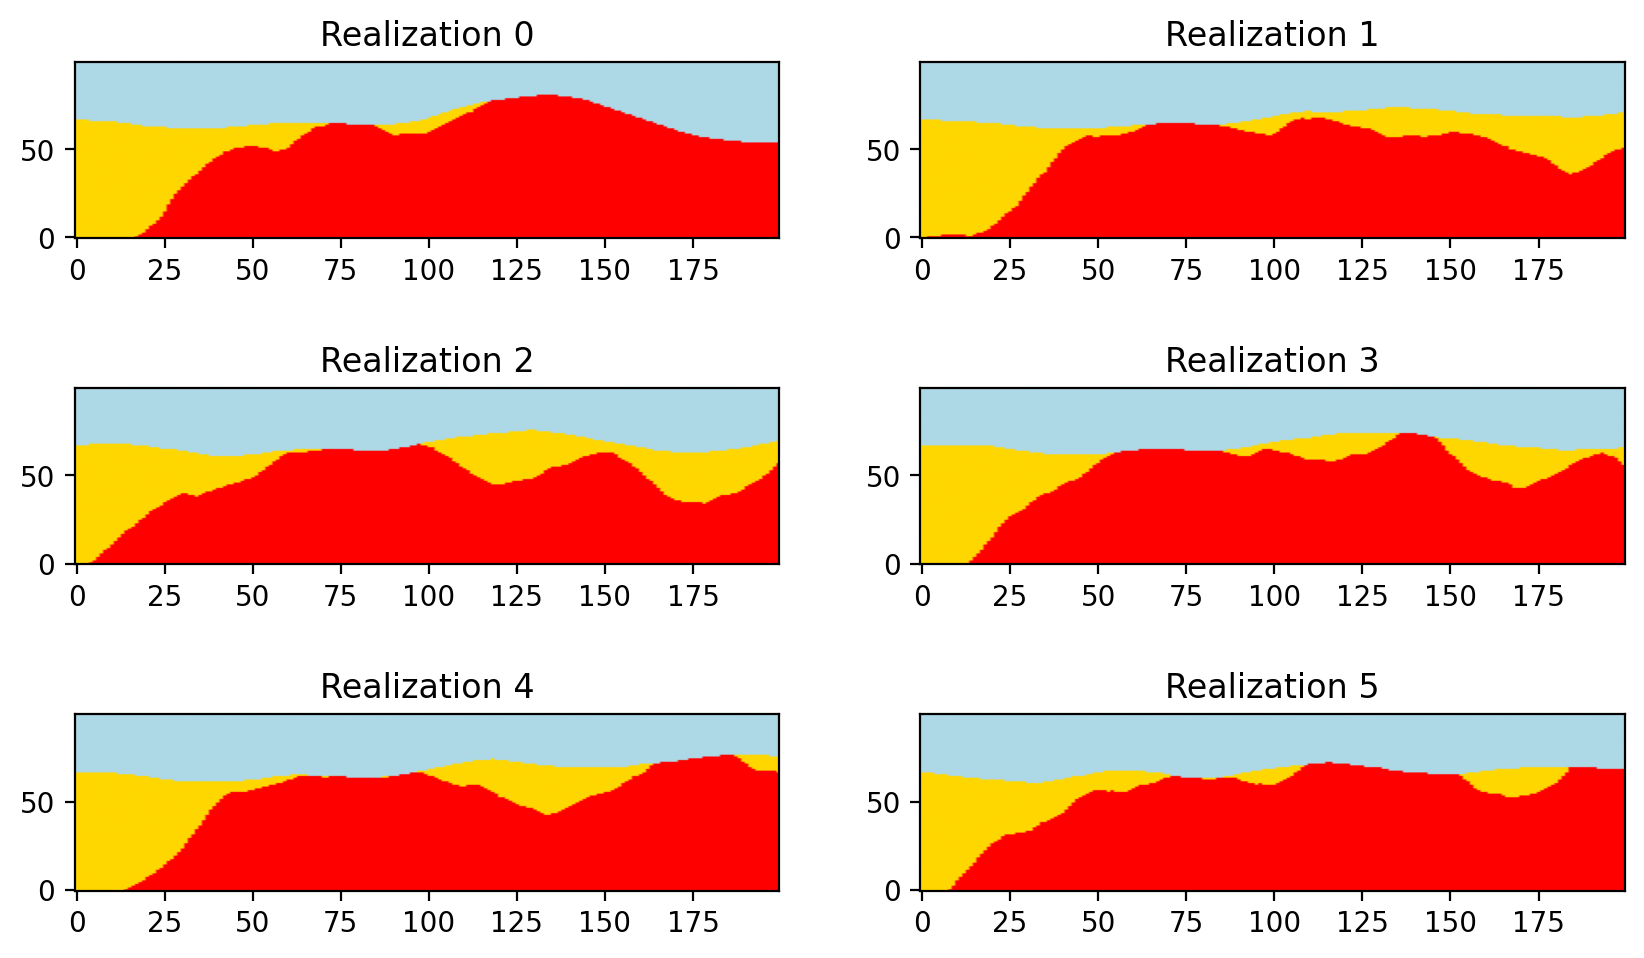

In [20]:
# re plots
plt.figure(figsize=(10, 6), dpi=200)
for i in range(6):
    
    plt.subplot(3, 2, i+1)
    plt.imshow(T1.get_units_domains_realizations(i, fill="color")[:, 0], origin="lower", aspect=.5)
    plt.title("Realization {}".format(i))

In [21]:
# 3D plot with boreholes
p = pv.Plotter()  # create a pyvista plotter...

T1.plot_units(0, plotter=p)  # put plotter in archpy plotting function...
T1.plot_bhs(plotter=p)  # put plotter in archpy plotting function...

p.show()  # ... and display !

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b6495170d0_1&reconnect=auto' style='width…

ArchPy also offers some functionnalities to deal with uncertainties and probabilities.

Try the ``plot_proba()`` method

In [22]:
# plot probability
T1.plot_proba(B)

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b6497fd610_2&reconnect=auto' style='width…

## Facies

Facies are easily integrated with ``ArchPy.base.Facies``. A facies can then be passed to the unit with the add_facies method. Warning, this method is an "adding" method it does not remove previously added facies. They should be remove manually wiht the following code : unit.list_facies = [].

As a remainder, C unit is uniformly composed of silts, B unit is composed of sand and gravel and A of silts and clay.

In [23]:
# Create facies
sand = ArchPy.base.Facies(ID = 1,name="Sand",color="yellow")
gravel = ArchPy.base.Facies(ID = 2,name="Gravel",color="lightgreen")
clay = ArchPy.base.Facies(ID = 4,name="Clay",color="blue")
silt = ArchPy.base.Facies(ID = 6,name="Silt",color="goldenrod")

C.add_facies([silt])
B.add_facies([sand, gravel])
A.add_facies([silt, clay])

Facies Silt added to unit C
Facies Sand added to unit B
Facies Gravel added to unit B
Facies Silt added to unit A
Facies Clay added to unit A


### Modify pile

Now, we have to modify the pile to indicate to ArchPy how to simulate these facies. We will use simple Sequential Indicator Simulations (**SIS**) in this exemple. SIS is on of the most simple geostatistical methods when it comes to facies modeling as it does not require many inputs. Indeed, it requires at least one covariance model for each unit. 
For simplicity of the example, these are given below (covmodel_SIS_A and covmodel_SIS_B). They represent the spatial variability of the facies that will be simulated.

Each facies methods have specific modeling parameters that are given to ArchPy by the use of a dictionnary (dic_facies). This dictionnary can have multiple entries such as:
   - f_method : filling method (SIS, MPS, homogenous, SubPile or TPGs) 
   - f_covmodel : facies covmodels to use with the SIS
   - probability : facies proportions, in the same order than the facies passed to the Unit.
   - (see ArchPy documentation for all the parameters)
  
 
Create these dictionnaries and add them to the corresponding units. There is no need to consider the proportions for this exercise.

In [24]:
# covariance models
covmodel_SIS_A = gcm.CovModel3D(elem = [("exponential", {"w":.25,"r":[20, 20, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B = gcm.CovModel3D(elem = [("exponential", {"w":.25,"r":[20, 20, 2]})], alpha=0, name="vario_SIS") # input variogram

dic_f_B = {"f_method" : "SIS", "neig" : 20, "f_covmodel": covmodel_SIS_B}
dic_f_A = {"f_method" : "SIS","neig" : 20, "f_covmodel" : covmodel_SIS_A}

B.set_dic_facies(dic_f_B)
A.set_dic_facies(dic_f_A)

Unit B: covmodel for SIS added
Unit A: covmodel for SIS added


### Re-add boreholes with facies this time

We need to reimport the boreholes with the facies information this time !

In [25]:
T1.rem_all_bhs()  # remove all boreholes

boreholes removed


In [26]:
boreholes = ArchPy.inputs.extract_bhs(db, lbhs, T1, extract_facies=True, vb=1)  # extract boreholes from database
T1.add_bh(boreholes)

Borehole 1 added
Borehole 2 added
Borehole 3 added
Borehole 4 added
Borehole 5 added


In [27]:

import pyvista
pl = pv.Plotter()
T1.plot_bhs("facies", plotter=pl, plot_bot=True, plot_top=True)
pl.camera_position = 'xz'


pl.show()

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b649806690_3&reconnect=auto' style='width…

### Reprocess and Rerun

Let's run again the simulations. This time 5 unit realizations and 5 facies realizations.

In [28]:
T1.process_bhs()  # process again because there is new boreholes

# simulations
T1.process_bhs()
T1.compute_surf(5)
T1.compute_facies(5)

##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set

 ## Computing distributions for Normal Score Transform ##

Processing ended successfully
##### ORDERING UNITS ##### 
Pile P1: ordering units
Stratigraphic units have been sorted according to order
hierarchical relations set
Boreholes already processed
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0029909610748291016 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.00498652458190918 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.001995563507080078 s

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.0039882659912109375 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.0039904

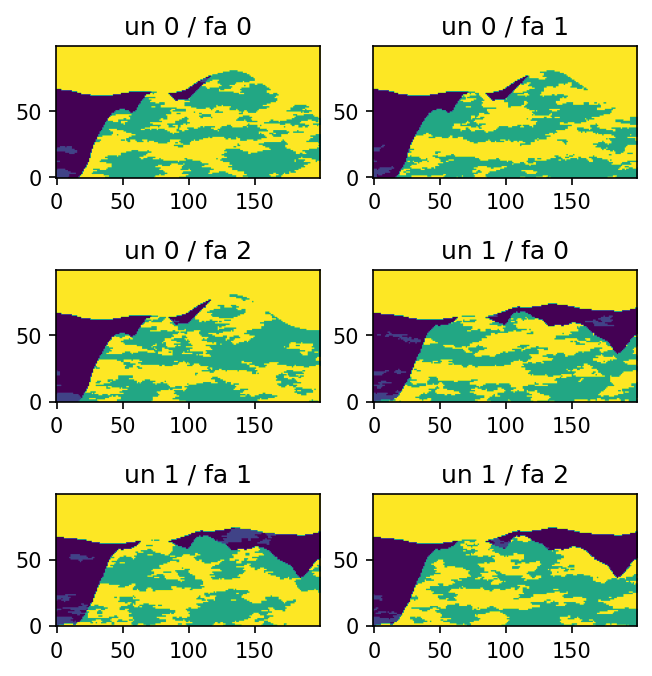

In [29]:
# plot
plt.figure(figsize=(5, 5.5), dpi=150)
for iu in range(2):
    for ifa in range(3):
    
        plt.subplot(3, 2, iu*3+ifa+1)
        plt.imshow(T1.get_facies(iu, ifa, all_data=False)[:, 0], origin="lower")
        plt.title("un {} / fa {}".format(iu, ifa))

In [30]:
p = pv.Plotter()

T1.plot_facies(0, 0, plotter=p)
T1.plot_bhs("facies", plotter=p)
p.show()

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b6494f8490_4&reconnect=auto' style='width…

## Property

Let's now add a phyiscal property: *log Hydraulic conductivity*. For recall, we assume a mean value of -3.5 for sand, -2 for gravel, -8 for clay and -6.5 for silt. 

We will create a property object with ``ArchPy.base.Prop``.

Important: Property objects are directly added to the project and not to the facies.

Arguments are : 
- name 
- facies (list, the facies in which to simulate the prop)
- covmodels (list, covariance models for the simulation, one for each facies, same order of facies) 
- means (list, mean values for the simulation, one for each facies)
- int_method (list, grf method --> SGS or FFT), which method to use to interpolate.
- x (position of the hard data, if any)
- v (values of the hard data, if any)
- def_mean (default value to use if a facies have not been added to the "facies" arguments
- vmin, vmax (min and max values for the properties, simulated values below (resp. above) will be capped.

In this example one property is defined for the four facies, each with a different covariance models given in list_covmodels, a list of 3D covmodels objects (see geone doc.). The order of the covmodels must be consistant with the order of the facies in list_facies. The same applies for the means parameter.

Finally the property is added to the project with the method ``Arch_table.add_project()``

In [31]:
T1.list_props = []

In [32]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[5,5,1]})], name="K_vario")

permea = ArchPy.base.Prop("K",[sand, gravel, clay, silt],
                  [covmodelK, covmodelK, covmodelK, covmodelK],
                  means=[-3.5,-2,-8,-6.5],
                  int_method = ["sgs","sgs","sgs","sgs"],
                  def_mean=-5)
# add prop to table
T1.add_prop([permea])

Property K added


And run simulations !

Set ``nreal = 2`` to start with

In [33]:
%%time
T1.compute_prop(2)

### 50 K property models will be modeled ###
### 2 K models done
### 4 K models done
### 6 K models done
### 8 K models done
### 10 K models done
### 12 K models done
### 14 K models done
### 16 K models done
### 18 K models done
### 20 K models done
### 22 K models done
### 24 K models done
### 26 K models done
### 28 K models done
### 30 K models done
### 32 K models done
### 34 K models done
### 36 K models done
### 38 K models done
### 40 K models done
### 42 K models done
### 44 K models done
### 46 K models done
### 48 K models done
### 50 K models done
CPU times: total: 17.3 s
Wall time: 2.57 s


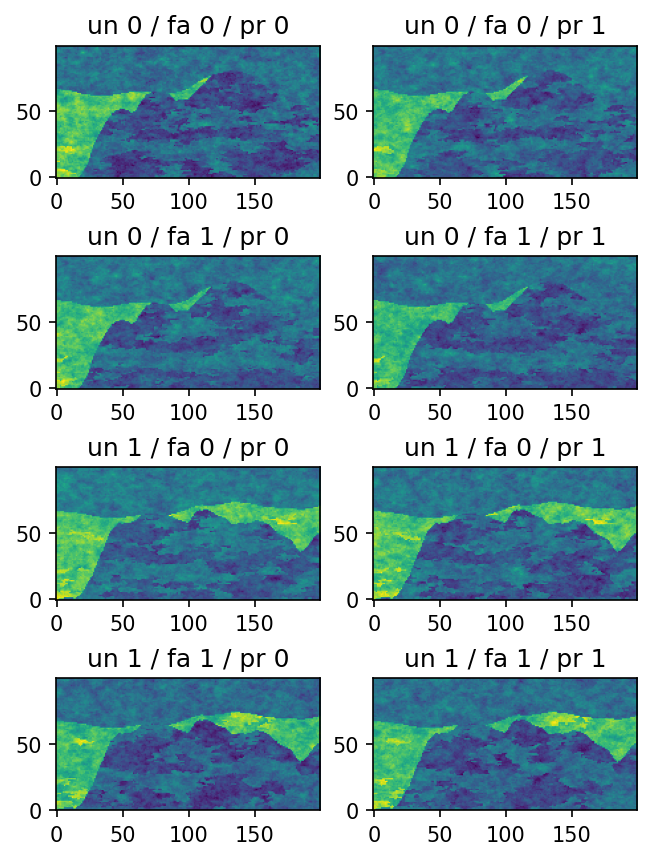

In [34]:
# Plots

plt.figure(figsize=(5, 7), dpi=150)
o = 1
for iu in range(2):
    for ifa in range(2):
        for ip in range(2):
            
            plt.subplot(4, 2, o)
            plt.imshow(T1.getprop("K", iu, ifa, ip, all_data=False)[:, 0], origin="lower")
            plt.title("un {} / fa {} / pr {}".format(iu, ifa, ip))
            
            o += 1     

In [35]:
#plot 3D
T1.plot_prop("K")

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b649585ad0_5&reconnect=auto' style='width…

In [36]:
# plot the mean
T1.plot_mean_prop("K")

Widget(value="<iframe src='http://localhost:60753/index.html?ui=P_0x1b6495e49d0_6&reconnect=auto' style='width…

Now you can play with the model and try different things. For example, you can try to modify the number of realizations and see how the mean evolve. Or you can add other simulations parameters such as facies proportions (``probability`` keys to put in ``dic_facies``).